In [1]:
%matplotlib notebook
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider
import matplotlib.gridspec as gridspec

Using MPI version 3.1, 1 processes


In [2]:
cell_size = mp.Vector3(5,5,5)

Si = mp.Medium(index=3.5)

h = 1.0
resolution = 30
geometry = [mp.Block(material=Si, size=mp.Vector3(2.5,h,2.0), center=mp.Vector3()),
    mp.Block(material=mp.air, size=mp.Vector3(1.5,h,1.6), center=mp.Vector3()),
    mp.Block(material=mp.air, size=mp.Vector3(0.5,h,0.4), center=mp.Vector3(-1.0,0,0))]
pml_layers = [mp.PML(1.0)]

sim = mp.Simulation(resolution=resolution,
                    geometry=geometry,
                    boundary_layers=pml_layers,
                    cell_size=cell_size,
                    eps_averaging=False)
sim.init_sim()

-----------
Initializing structure...
     block, center = (0,0,0)
          size (2.5,1,2)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (1.5,1,1.6)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1,0,0)
          size (0.5,1,0.4)
          axes (1,0,0), (0,1,0), (0,0,1)


<IPython.core.display.Javascript object>


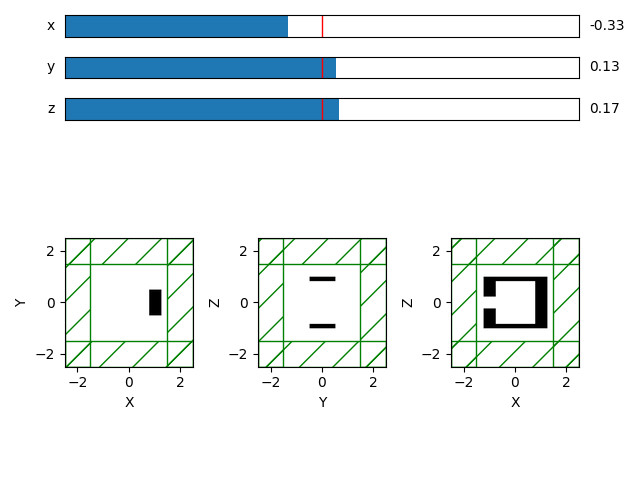

In [3]:
def visualize_slices():
        if not sim._is_initialized:
            sim.init_sim()
        
        gs = gridspec.GridSpec(4, 3,height_ratios=[1,1,1,15])

        xmin = sim.geometry_center.x - sim.cell_size.x/2
        xmax = sim.geometry_center.x + sim.cell_size.x/2
        ymin = sim.geometry_center.y - sim.cell_size.y/2
        ymax = sim.geometry_center.y + sim.cell_size.y/2
        zmin = sim.geometry_center.z - sim.cell_size.z/2
        zmax = sim.geometry_center.z + sim.cell_size.z/2

        f = plt.figure()

        b1 = plt.subplot(gs[0:3])
        b2 = plt.subplot(gs[3:6])
        b3 = plt.subplot(gs[6:9])
        ax1 = plt.subplot(gs[9])
        ax2 = plt.subplot(gs[10])
        ax3 = plt.subplot(gs[11])

        xSlider = Slider(b1, 'x', xmin, xmax, valinit=0, valstep=1/sim.resolution)
        ySlider = Slider(b2, 'y', ymin, ymax, valinit=0, valstep=1/sim.resolution)
        zSlider = Slider(b3, 'z', zmin, zmax, valinit=0, valstep=1/sim.resolution)

        def update(val):
            ax1.clear()
            ax2.clear()
            ax3.clear()
            x = xSlider.val
            y = ySlider.val
            z = zSlider.val
            sim.plot2D(ax=ax1,x=None,y=None,z=z)
            sim.plot2D(ax=ax2,x=x,y=None,z=None)
            sim.plot2D(ax=ax3,x=None,y=y,z=None)
            plt.tight_layout()

        xSlider.on_changed(update)
        ySlider.on_changed(update)
        zSlider.on_changed(update)

        ax1.clear()
        ax2.clear()
        ax3.clear()

        # ititialize
        sim.plot2D(ax=ax1,x=None,y=None,z=0)
        sim.plot2D(ax=ax2,x=0,y=None,z=None)
        sim.plot2D(ax=ax3,x=None,y=0,z=None)
        plt.tight_layout()

        return f

f = visualize_slices()    
plt.show()

In [7]:
gdsII_file = 'coupler.gds'
CELL_LAYER = 0
PORT1_LAYER = 1
PORT2_LAYER = 2
PORT3_LAYER = 3
PORT4_LAYER = 4
SOURCE_LAYER = 5
UPPER_BRANCH_LAYER = 31
LOWER_BRANCH_LAYER = 32
default_d = 0.3

t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

dpml = 1
cell_thickness = dpml+t_oxide+t_Si+t_air+dpml
si_zmin = 0

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

three_d = True
d = 0.2
resolution = 10

cell_zmax = 0.5*cell_thickness if three_d else 0
cell_zmin = -0.5*cell_thickness if three_d else 0
si_zmax = t_Si if three_d else 0

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
upper_branch = mp.get_GDSII_prisms(silicon, gdsII_file, UPPER_BRANCH_LAYER, si_zmin, si_zmax)
lower_branch = mp.get_GDSII_prisms(silicon, gdsII_file, LOWER_BRANCH_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)
p3 = mp.GDSII_vol(gdsII_file, PORT3_LAYER, si_zmin, si_zmax)
p4 = mp.GDSII_vol(gdsII_file, PORT4_LAYER, si_zmin, si_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)

# displace upper and lower branches of coupler (as well as source and flux regions)
if d != default_d:
    delta_y = 0.5*(d-default_d)
    delta = mp.Vector3(y=delta_y)
    p1.center += delta
    p2.center -= delta
    p3.center += delta
    p4.center -= delta
    src_vol.center += delta
    cell.size += 2*delta
    for np in range(len(lower_branch)):
        lower_branch[np].center -= delta
        for nv in range(len(lower_branch[np].vertices)):
            lower_branch[np].vertices[nv] -= delta
    for np in range(len(upper_branch)):
        upper_branch[np].center += delta
        for nv in range(len(upper_branch[np].vertices)):
            upper_branch[np].vertices[nv] += delta

geometry = upper_branch+lower_branch

if three_d:
    oxide_center = mp.Vector3(z=-0.5*t_oxide)
    oxide_size = mp.Vector3(cell.size.x,cell.size.y,t_oxide)
    oxide_layer = [mp.Block(material=oxide, center=oxide_center, size=oxide_size)]
    geometry = geometry+oxide_layer

sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                                size=src_vol.size,
                                center=src_vol.center,
                                eig_band=1,
                                eig_parity=mp.NO_PARITY if three_d else mp.EVEN_Y+mp.ODD_Z,
                                eig_match_freq=True)]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    eps_averaging = False,
                    geometry=geometry)

mode1 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p2))
mode3 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p3))
mode4 = sim.add_mode_monitor(fcen, 0, 1, mp.ModeRegion(volume=p4))
sim.init_sim()

-----------
Initializing structure...
     prism, center = (-9.09425,1.36149,0.11)
          height 0.22, axis (0,0,1), 174 vertices:
          (-4,0.1,0)
          (-4.108,0.101,0)
          (-4.215,0.102,0)
          (-4.322,0.105,0)
          (-4.429,0.11,0)
          (-4.535,0.115,0)
          (-4.641,0.121,0)
          (-4.747,0.129,0)
          (-4.852,0.137,0)
          (-5.062,0.157,0)
          (-5.167,0.169,0)
          (-5.271,0.181,0)
          (-5.479,0.209,0)
          (-5.582,0.224,0)
          (-5.685,0.24,0)
          (-5.788,0.257,0)
          (-5.891,0.275,0)
          (-5.993,0.293,0)
          (-6.095,0.312,0)
          (-6.197,0.332,0)
          (-6.299,0.353,0)
          (-6.4,0.374,0)
          (-6.501,0.396,0)
          (-6.703,0.442,0)
          (-6.803,0.465,0)
          (-6.904,0.49,0)
          (-7.204,0.565,0)
          (-7.303,0.592,0)
          (-7.403,0.618,0)
          (-7.502,0.645,0)
          (-7.601,0.673,0)
          (-7.7,0.7,0)
          (-7.799

          (9.658,1.29,0)
          (9.56,1.26,0)
          (9.463,1.231,0)
          (9.366,1.201,0)
          (9.268,1.171,0)
          (9.074,1.111,0)
          (8.878,1.051,0)
          (8.781,1.021,0)
          (8.585,0.961,0)
          (8.487,0.932,0)
          (8.389,0.902,0)
          (8.291,0.873,0)
          (8.193,0.843,0)
          (8.095,0.814,0)
          (7.996,0.785,0)
          (7.898,0.757,0)
          (7.799,0.728,0)
          (7.7,0.7,0)
          (7.601,0.673,0)
          (7.502,0.645,0)
          (7.403,0.618,0)
          (7.303,0.592,0)
          (7.204,0.565,0)
          (6.904,0.49,0)
          (6.803,0.465,0)
          (6.703,0.442,0)
          (6.501,0.396,0)
          (6.4,0.374,0)
          (6.299,0.353,0)
          (6.197,0.332,0)
          (6.095,0.312,0)
          (5.993,0.293,0)
          (5.891,0.275,0)
          (5.788,0.257,0)
          (5.685,0.24,0)
          (5.582,0.224,0)
          (5.479,0.209,0)
          (5.271,0.181,0)
          (5.167,0.169,

          (6.394,-0.884,0)
          (6.296,-0.863,0)
          (6.198,-0.843,0)
          (6.099,-0.823,0)
          (6.001,-0.804,0)
          (5.902,-0.785,0)
          (5.804,-0.767,0)
          (5.705,-0.75,0)
          (5.606,-0.734,0)
          (5.408,-0.704,0)
          (5.309,-0.69,0)
          (5.209,-0.678,0)
          (5.11,-0.666,0)
          (5.01,-0.655,0)
          (4.81,-0.635,0)
          (4.709,-0.627,0)
          (4.608,-0.62,0)
          (4.508,-0.614,0)
          (4.407,-0.609,0)
          (4.305,-0.605,0)
          (4.204,-0.602,0)
          (4,-0.6,0)
          (4,-0.1,0)
          (4.108,-0.101,0)
          (4.215,-0.102,0)
          (4.322,-0.105,0)
          (4.429,-0.11,0)
          (4.535,-0.115,0)
          (4.641,-0.121,0)
          (4.747,-0.129,0)
          (4.852,-0.137,0)
          (5.062,-0.157,0)
          (5.167,-0.169,0)
          (5.271,-0.181,0)
          (5.479,-0.209,0)
          (5.582,-0.224,0)
          (5.685,-0.24,0)
          (5.788,-0.2

<IPython.core.display.Javascript object>


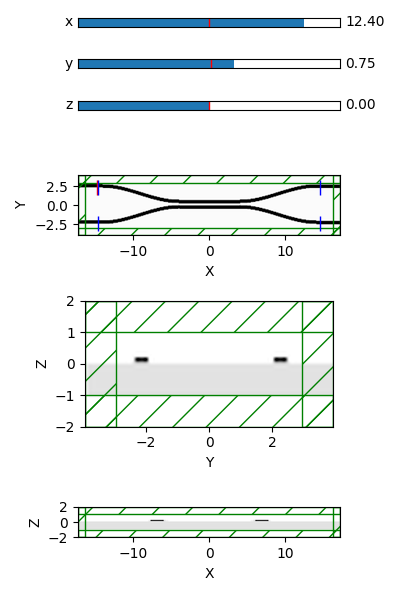

In [12]:
def visualize_slices():
        if not sim._is_initialized:
            sim.init_sim()
        
        gs = gridspec.GridSpec(6, 1,height_ratios=[1,1,1,14,14,14])

        xmin = sim.geometry_center.x - sim.cell_size.x/2
        xmax = sim.geometry_center.x + sim.cell_size.x/2
        ymin = sim.geometry_center.y - sim.cell_size.y/2
        ymax = sim.geometry_center.y + sim.cell_size.y/2
        zmin = sim.geometry_center.z - sim.cell_size.z/2
        zmax = sim.geometry_center.z + sim.cell_size.z/2

        f = plt.figure(figsize=(4,6))

        b1 = plt.subplot(gs[0])
        b2 = plt.subplot(gs[1])
        b3 = plt.subplot(gs[2])
        ax1 = plt.subplot(gs[3])
        ax2 = plt.subplot(gs[4])
        ax3 = plt.subplot(gs[5])

        xSlider = Slider(b1, 'x', xmin, xmax, valinit=0, valstep=1/sim.resolution)
        ySlider = Slider(b2, 'y', ymin, ymax, valinit=0, valstep=1/sim.resolution)
        zSlider = Slider(b3, 'z', zmin, zmax, valinit=0, valstep=1/sim.resolution)

        def update(val):
            ax1.clear()
            ax2.clear()
            ax3.clear()
            x = xSlider.val
            y = ySlider.val
            z = zSlider.val
            sim.plot2D(ax=ax1,x=None,y=None,z=z)
            sim.plot2D(ax=ax2,x=x,y=None,z=None)
            sim.plot2D(ax=ax3,x=None,y=y,z=None)
            plt.tight_layout()

        xSlider.on_changed(update)
        ySlider.on_changed(update)
        zSlider.on_changed(update)

        ax1.clear()
        ax2.clear()
        ax3.clear()

        # ititialize
        sim.plot2D(ax=ax1,x=None,y=None,z=0)
        sim.plot2D(ax=ax2,x=0,y=None,z=None)
        sim.plot2D(ax=ax3,x=None,y=0,z=None)
        plt.tight_layout()

        return f

f = visualize_slices()    
plt.show()